In [1]:
import warnings
from itertools import product
import glob
from datetime import datetime
from datetime import timedelta
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cartopy.feature as cf
import shapely.geometry as sgeom
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


from sklearn.decomposition import PCA
from scipy import stats
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.metrics import davies_bouldin_score

import pickle
import copy
from shapely import geometry
from sklearn.metrics.pairwise import euclidean_distances
import statsmodels.api as sm
from scipy.stats import linregress
from sklearn.metrics import accuracy_score
import math
import matplotlib.lines as mlines
from scipy.stats import ks_2samp

In [2]:
path_anoms = '/glade/derecho/scratch/jhayron/Data4WRsClimateChange/LENS_poly_v3/'
files = np.sort(glob.glob(f'{path_anoms}*'))
names_exp = np.array([files[id_exp].split('_')[-1][:-7] for id_exp in range(len(files))])

In [3]:
import pandas as pd
import xarray as xr

# Create a dictionary to store data for all experiments
data_dict = {}

# Read data for all experiments and store them in the dictionary
for id_exp, exp_name in enumerate(names_exp):
    # Read the labels dataframe
    labels_df = pd.read_csv(f'../Data_v4/LENS2/Labels/df_labels_{exp_name}.csv',
                            index_col=0, parse_dates=True, names=['WR'], skiprows=1)
    
    # Read the distances dataframe
    distances_df = pd.read_csv(f'../Data_v4/LENS2/Distances/df_labels_{exp_name}.csv',
                               index_col=0, parse_dates=True, names=['distance'], skiprows=1)
    
    # Read the composites/averages xarray DataArray
    composites_da = xr.open_dataset(f'../Data_v4/LENS2/avgs/avgs_{exp_name}.nc').Z_anoms
    
    # Store the read data in the dictionary under the experiment name
    data_dict[exp_name] = {'labels': labels_df, 'distances': distances_df, 'composites': composites_da}



In [4]:
# Define a function to convert a date into a season
def get_season(date):
    """Map a date to its corresponding season."""
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

# Loop through each experiment in the data dictionary
for exp_name, data in data_dict.items():
    # Assuming data['labels'] is a DataFrame with a 'time' column of datetime type
    # if 'time' in data['labels'].columns:
    # Add a new column 'season' to the labels DataFrame based on the 'time' column
    data['labels']['season'] = data['labels'].index.map(get_season)
    data['distances']['season'] = data['labels'].index.map(get_season)
    # else:
    #     print(f"Experiment {exp_name} does not have a 'time' column in its labels DataFrame.")

In [16]:
names_wrs = ["Pacific High","Pacific Trough","Greenland High","Atlantic High","No WR"]
names = ["Pacific High","Pacific Trough","Greenland High","Atlantic High","No WR"]

In [6]:
def get_events(df_labels):
    # Step 1: Identify changes in class to find the start of each event
    df_labels['shifted'] = df_labels['WR'].shift(1)
    df_labels['start'] = df_labels['WR'] != df_labels['shifted']
    df_labels['start_date'] = df_labels.index.where(df_labels['start'], pd.NaT)
    df_labels['start_date'].fillna(method='ffill', inplace=True)
    
    # Step 2: Calculate the duration of each event
    # Convert the Timedelta to its 'days' component
    df_labels['duration'] = (df_labels.index - df_labels['start_date']).dt.days + 1
    
    # Step 3: Create the df_events DataFrame
    # Group by 'start_date' and 'class' to get the duration of each class event
    df_events = df_labels.groupby(['start_date', 'WR']).agg({'duration': 'max'}).reset_index()
    
    # Drop the temporary columns used for calculations
    df_labels.drop(columns=['shifted', 'start', 'start_date', 'duration'], inplace=True)
    
    # Set 'start_date' as the index if needed
    df_events.set_index('start_date', inplace=True)
    
    return df_events

In [7]:
for exp_name in names_exp:
    data_dict[exp_name]['events'] = get_events(data_dict[exp_name]['labels'])
    
for exp_name, data in data_dict.items():
    # Assuming data['labels'] is a DataFrame with a 'time' column of datetime type
    # if 'time' in data['labels'].columns:
    # Add a new column 'season' to the labels DataFrame based on the 'time' column
    data['events']['season'] = data['events'].index.map(get_season)

In [8]:
def extract_n_years_around_each_year(df, N):
    """
    Extracts N years of data around each year from the input DataFrame.

    Parameters:
    - df (DataFrame): Input DataFrame containing time-indexed data.
    - N (int): Number of years to extract around each year.

    Returns:
    - dict: A dictionary where each key is a year and the corresponding value is a DataFrame
            containing N years of data centered around that year.
    """
    # Initialize an empty dictionary to store results
    result_dict = {}

    # Iterate over each unique year in the index
    for year in df.index.year.unique():
        # Define the range of years to extract
        start_year = year - N
        end_year = year
        
        # start_year = year - N
        # end_year = year

        # Extract data for the range of years
        data_subset = df[(df.index.year >= start_year) & (df.index.year <= end_year)]

        # Store the extracted data in the result dictionary
        result_dict[year] = data_subset

    return result_dict
    
def get_frequencies_labels(df_labels_temp):
    # 1. Compute Overall Frequency of Each Class
    overall_frequency = df_labels_temp['WR'].value_counts().sort_index()
    overall_frequency = overall_frequency*100/np.sum(overall_frequency)

    # Group by season and class to count the frequency
    seasonal_frequency = df_labels_temp.groupby(['season', 'WR']).size().unstack(fill_value=0)
    seasonal_percentage = seasonal_frequency.div(seasonal_frequency.sum(axis=1), axis=0) * 100
    return overall_frequency,seasonal_percentage

def get_event_freqs(df_events_temp):
    # Total number of events for each class
    total_events_per_class = df_events_temp.groupby('WR').size()
    years = df_events_temp.index.year
    total_years = years.nunique()
    # Calculate the average frequency of events per year for each class
    average_frequency_per_year = total_events_per_class / total_years
    # Calculate the number of events for each class per season
    events_per_season = df_events_temp.groupby(['WR', 'season']).size().unstack(fill_value=0)
    # Calculate the average frequency of events per season for each class
    # Number of unique years might differ if not every season is present each year
    average_frequency_per_season = events_per_season / total_years
    return average_frequency_per_year, average_frequency_per_season

def get_durations_events(df_events_temp):
    mean_duration_overall = df_events_temp.groupby('WR')['duration'].mean()
    # Calculate mean duration of events for each class stratified by seasons
    mean_duration_by_season = df_events_temp.groupby(['season', 'WR'])['duration'].mean()
    # mean_duration_by_season = mean_duration_by_season.reindex(range(6), fill_value=0)
    return mean_duration_overall, mean_duration_by_season

In [9]:
def get_time_series_of_frequencies(df_labels, N=30):
    dict_labels = extract_n_years_around_each_year(df_labels, N)
    years_trends = df_labels.index.year.unique()[N:]
    seasons = ['Winter', 'Spring', 'Summer', 'Fall']
    series_frequencies = []
    series_frequencies_seasonal = {}
    for season in seasons:
        series_frequencies_seasonal[season] = []
    
    for year in years_trends:
        series_frequencies.append(get_frequencies_labels(dict_labels[year])[0].values)
        for season in seasons:
            series_frequencies_seasonal[season].append(get_frequencies_labels(dict_labels[year])[1].loc[season])
    
    series_frequencies = np.array(series_frequencies)
    for season in seasons:
        series_frequencies_seasonal[season] = pd.DataFrame(np.array(series_frequencies_seasonal[season]), index = years_trends)
    series_frequencies_seasonal['all'] = pd.DataFrame(series_frequencies, index = years_trends)
    return series_frequencies_seasonal

In [10]:
def compute_trend_significance(series):
    ### COMPUTE TRENDS AND SIGNIFICANCE
    # Linear regression using statsmodels
    X = sm.add_constant(series.index)  # Add a constant (intercept) to the model
    model = sm.OLS(series, X).fit()  # Fit the model
    # Extract the slope (trend) and its p-value
    # return model
    s = model.params.x1
    p = model.pvalues.x1
    return s, p

In [11]:
def compute_significance_approval_30(series,n):
    slope1, p_value1 = compute_trend_significance(series)
    alpha = 0.05
    if (p_value1<alpha):
        return True
    else:
        return False

In [12]:
dics_distances_30 = np.load('../Data_v4/SeriesCharacteristics/dics_distances_30.npy',allow_pickle=True)[()]
dics_durations_30 = np.load('../Data_v4/SeriesCharacteristics/dics_durations_30.npy',allow_pickle=True)[()]
dics_freqs_30 = np.load('../Data_v4/SeriesCharacteristics/dics_freqs_30.npy',allow_pickle=True)[()]
dics_evfreqs_30 = np.load('../Data_v4/SeriesCharacteristics/dics_evfreqs_30.npy',allow_pickle=True)[()]

In [13]:
seasons2 = ['Winter', 'Spring', 'Summer', 'Fall', 'all']

In [14]:
dics_freqs_ts_0 = {}
for exp_name in names_exp:
    dics_freqs_ts_0[exp_name] = get_time_series_of_frequencies(data_dict[exp_name]['labels'],30)

In [17]:
dic_freqs_ts = {}

for season in seasons2:
    dic_freqs_ts[season] = {}
    for wr in range(len(names)):
        dic_temp = {}
        for exp_name in names_exp:
            dic_temp[exp_name] = dics_freqs_ts_0[exp_name][season][wr]
        dic_freqs_ts[season][wr] = pd.DataFrame(dic_temp)

In [18]:
start_years_exps = np.array([names_exp[i].split('-')[1][:4] for i in range(len(names_exp))])

In [19]:
unique_years, counts = np.unique(start_years_exps, return_counts=True)

# Display the results
for elem, count in zip(unique_years, counts):
    print(f"Element {elem} appears {count} times")

Element 1011 appears 1 times
Element 1031 appears 1 times
Element 1051 appears 1 times
Element 1071 appears 1 times
Element 1091 appears 1 times
Element 1111 appears 1 times
Element 1131 appears 1 times
Element 1151 appears 1 times
Element 1171 appears 1 times
Element 1191 appears 1 times
Element 1231 appears 10 times
Element 1251 appears 10 times
Element 1281 appears 10 times
Element 1301 appears 10 times


In [20]:
start_years_macro = ['1231', '1251', '1281', '1301']

In [21]:
names_wrs = ["Pacific High","Pacific Trough","Greenland High","Atlantic High","No WR"]

In [24]:
for macro_year in start_years_macro:
    import matplotlib.lines as mlines
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
    season_titles = ['Winter', 'Spring', 'Summer', 'Fall', 'All year']
    alpha=0.05
    
    fig, axes = plt.subplots(nrows=len(names_wrs), ncols=5, figsize=(15, 10))  # Adjust figsize to accommodate more subplots
    axes = axes.flatten()
    
    # Iterate over each weather regime (rows)
    for wr in range(len(names_wrs)):
        # Iterate over each season (columns)
        for iseason, season in enumerate(['Winter', 'Spring', 'Summer', 'Fall', 'all']):
            ax = axes[wr * 5 + iseason]

            names_exps_macro = names_exp[start_years_exps==macro_year]
            
            df_temp_30 = dic_freqs_ts[season][wr][names_exps_macro].mean(axis=1)
            ax.plot(df_temp_30, color=colors[wr], ls='solid', zorder=10, lw=2)
            p5=dic_freqs_ts[season][wr][names_exps_macro].min(axis=1)
            p95=dic_freqs_ts[season][wr][names_exps_macro].max(axis=1)
            ax.fill_between(df_temp_30.index, p5, p95, color=colors[wr], alpha=0.3)
            # Plot other reanalyses with dashed lines if significance is approved
            approval30 = compute_significance_approval_30(df_temp_30, 30)
            if approval30:
                for spine in ax.spines.values():
                    spine.set_linewidth(3)  # Set the thickness of the border (default is 1)
            
            pvals = []
            trends = []
            ax.plot(dics_freqs_30['ERA5'][season][wr], color='k', ls='solid', zorder=10, lw=2)
            
            for name_exp in names_exps_macro:
                df_temp_30 = dic_freqs_ts[season][wr][name_exp]
                trend, pval = compute_trend_significance(df_temp_30)
                pvals.append(pval)
                trends.append(trend)
                ax.plot(df_temp_30, color='k', ls='solid', zorder=0, lw=0.5,alpha=0.3)
            
            pvals = np.array(pvals)
            trends = np.array(trends)
            
            conf_pos = 100 * len(np.where((trends>0)&(pvals<=alpha))[0])/len(trends)
            conf_neg = 100 * len(np.where((trends<0)&(pvals<=alpha))[0])/len(trends)
            conf_neu = 100 * len(np.where((pvals>=alpha))[0])/len(trends)
            text_trend = f"{np.round(conf_pos,0)}%>0, {np.round(conf_neg,0)}%<0, {np.round(conf_neu,0)}%=0"
            ax.set_title(text_trend)
            # Set the title for each season column (first row only)
            if wr == 0:
                ax.set_title(season_titles[iseason]+"\n"+text_trend, fontsize=13)
            
            # Set y-axis label for the first column in each row
            if iseason == 0:
                ax.set_ylabel(f'{names_wrs[wr]}\n[%]', fontsize=13)
            else:
                ax.set_ylabel(f'[%]', fontsize=13)
    
            # ax.set_ylim(p5.min()*0.98,p95.max()*1.02)
            # Add transparent gridlines
            ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    
            # Set font sizes for axes labels
            ax.tick_params(axis='both', which='major', labelsize=10)
    
    # Add a main title to the entire plot
    fig.suptitle(f"Trends in Frequency - Start year: {macro_year}", fontsize=18, y=0.95, x=0.2)
    
    # Adjust layout to prevent overlapping
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    # Create custom legend handles for the top-right corner
    legend_lines = [
        mlines.Line2D([], [], color=colors[0], linestyle='solid', label='LENS mean'),
        # mlines.Line2D([], [], color=colors[0], linestyle='dashed', label='ERA5 5-yr window'),
        mlines.Line2D([], [], color='k', linestyle='solid', label='LENS ensemble member'),
        # mlines.Line2D([], [], color='k', linestyle='dotted', label='Other reanalyses 5-yr window')
    ]
    
    # Add the legend to the top right of the figure
    fig.legend(handles=legend_lines,ncol=2, loc='upper right', bbox_to_anchor=(0.98, 0.96), fontsize=10, frameon=False)
    
    plt.savefig(f'../Figures_v4/LENS_Trends/LENS_FrequencyTrends_{macro_year}.png')
    plt.close('all')

In [25]:
def get_time_series_of_eventfreqs(df_events, N=30):
    dict_events = extract_n_years_around_each_year(df_events, N)
    years_trends = df_events.index.year.unique().values[N:]
    # print(years_trends)
    # print(years_trends)
    seasons = ['Winter', 'Spring', 'Summer', 'Fall']
    series_evfreq = []
    series_evfreq_seasonal = {}
    for season in seasons:
        series_evfreq_seasonal[season] = []
    
    for year in years_trends:
        series_evfreq.append(get_event_freqs(dict_events[year])[0].values)
        for season in seasons:
            series_evfreq_seasonal[season].append(get_event_freqs(dict_events[year])[1][season])
    
    series_evfreq = np.array(series_evfreq)
    for season in seasons:
        series_evfreq_seasonal[season] = pd.DataFrame(np.array(series_evfreq_seasonal[season]),index=years_trends)

    series_evfreq_seasonal['all'] = pd.DataFrame(series_evfreq,index=years_trends)
    return series_evfreq_seasonal

In [26]:
dics_evfreqs_ts_0 = {}
for exp_name in names_exp:
    dics_evfreqs_ts_0[exp_name] = get_time_series_of_eventfreqs(data_dict[exp_name]['events'],30)

In [27]:
dic_evfreqs_ts = {}

for season in seasons2:
    dic_evfreqs_ts[season] = {}
    for wr in range(len(names)):
        dic_temp = {}
        for exp_name in names_exp:
            dic_temp[exp_name] = dics_evfreqs_ts_0[exp_name][season][wr]
        dic_evfreqs_ts[season][wr] = pd.DataFrame(dic_temp)

In [28]:
for macro_year in start_years_macro:
    import matplotlib.lines as mlines
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
    season_titles = ['Winter', 'Spring', 'Summer', 'Fall', 'All year']
    alpha=0.05
    
    fig, axes = plt.subplots(nrows=len(names_wrs), ncols=5, figsize=(15, 10))  # Adjust figsize to accommodate more subplots
    axes = axes.flatten()
    
    # Iterate over each weather regime (rows)
    for wr in range(len(names_wrs)):
        # Iterate over each season (columns)
        for iseason, season in enumerate(['Winter', 'Spring', 'Summer', 'Fall', 'all']):
            ax = axes[wr * 5 + iseason]
            names_exps_macro = names_exp[start_years_exps==macro_year]
            df_temp_30 = dic_evfreqs_ts[season][wr][names_exps_macro].mean(axis=1)
            ax.plot(df_temp_30, color=colors[wr], ls='solid', zorder=10, lw=2)
            p5=dic_evfreqs_ts[season][wr][names_exps_macro].min(axis=1)
            p95=dic_evfreqs_ts[season][wr][names_exps_macro].max(axis=1)
            ax.fill_between(df_temp_30.index, p5, p95, color=colors[wr], alpha=0.3)
            ax.plot(dics_evfreqs_30['ERA5'][season][wr], color='k', ls='solid', zorder=10, lw=2)
            
            # Plot other reanalyses with dashed lines if significance is approved
            approval30 = compute_significance_approval_30(df_temp_30, 30)
            if approval30:
                for spine in ax.spines.values():
                    spine.set_linewidth(3)  # Set the thickness of the border (default is 1)
            
            pvals = []
            trends = []
            
            for name_exp in names_exps_macro:
                df_temp_30 = dic_evfreqs_ts[season][wr][name_exp]
                trend, pval = compute_trend_significance(df_temp_30)
                pvals.append(pval)
                trends.append(trend)
                ax.plot(df_temp_30, color='k', ls='solid', zorder=0, lw=0.5,alpha=0.3)
            
            pvals = np.array(pvals)
            trends = np.array(trends)
            
            conf_pos = 100 * len(np.where((trends>0)&(pvals<=alpha))[0])/len(trends)
            conf_neg = 100 * len(np.where((trends<0)&(pvals<=alpha))[0])/len(trends)
            conf_neu = 100 * len(np.where((pvals>=alpha))[0])/len(trends)
            text_trend = f"{np.round(conf_pos,0)}%>0, {np.round(conf_neg,0)}%<0, {np.round(conf_neu,0)}%=0"
            ax.set_title(text_trend)
            # Set the title for each season column (first row only)
            if wr == 0:
                ax.set_title(season_titles[iseason]+"\n"+text_trend, fontsize=13)
            
            # Set y-axis label for the first column in each row
            if iseason == 0:
                ax.set_ylabel(f'{names_wrs[wr]}\n[events/season]', fontsize=13)
            else:
                ax.set_ylabel(f'[events/season]', fontsize=13)
            # ax.set_ylim(p5.min()*0.98,p95.max()*1.02)
            # Add transparent gridlines
            ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    
            # Set font sizes for axes labels
            ax.tick_params(axis='both', which='major', labelsize=10)
    
    # Add a main title to the entire plot
    fig.suptitle(f"Trends in Number of Events - Start year: {macro_year}", fontsize=18, y=0.95, x=0.2)
    
    # Adjust layout to prevent overlapping
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    # Create custom legend handles for the top-right corner
    legend_lines = [
        mlines.Line2D([], [], color=colors[0], linestyle='solid', label='LENS mean'),
        # mlines.Line2D([], [], color=colors[0], linestyle='dashed', label='ERA5 5-yr window'),
        mlines.Line2D([], [], color='k', linestyle='solid', label='LENS ensemble member'),
        # mlines.Line2D([], [], color='k', linestyle='dotted', label='Other reanalyses 5-yr window')
    ]
    
    # Add the legend to the top right of the figure
    fig.legend(handles=legend_lines,ncol=2, loc='upper right', bbox_to_anchor=(0.98, 0.96), fontsize=10, frameon=False)
    
    plt.savefig(f'../Figures_v4/LENS_Trends/LENS_NEventsTrends_{macro_year}.png')
    plt.close('all')

In [29]:
def get_time_series_of_durations(df_events, N=30):
    dict_events = extract_n_years_around_each_year(df_events, N)
    years_trends = df_events.index.year.unique().values[N:]
    seasons = ['Winter', 'Spring', 'Summer', 'Fall']
    series_duration = []
    series_duration_seasonal = {}
    for season in seasons:
        series_duration_seasonal[season] = []
    
    for year in years_trends:
        series_duration.append(get_durations_events(dict_events[year])[0].values)
        for season in seasons:
            series_duration_seasonal[season].append(get_durations_events(dict_events[year])[1][season])
    
    series_duration = np.array(series_duration)
    for season in seasons:
        # print(season)
        # # print(series_duration_seasonal[season])
        # print(years_trends.shape)
        # if season=='Spring':
        #     return series_duration_seasonal#[season]
        # print(len(series_duration_seasonal[season]))
        series_duration_seasonal[season] = pd.DataFrame(np.array(series_duration_seasonal[season]),index=years_trends)
    series_duration_seasonal['all'] = pd.DataFrame(series_duration,index=years_trends)
    return series_duration_seasonal

In [30]:
dics_durs_ts_0 = {}
for exp_name in names_exp:
    dics_durs_ts_0[exp_name] = get_time_series_of_durations(data_dict[exp_name]['events'],30)

In [31]:
dic_durs_ts = {}

for season in seasons2:
    dic_durs_ts[season] = {}
    for wr in range(len(names)):
        dic_temp = {}
        for exp_name in names_exp:
            dic_temp[exp_name] = dics_durs_ts_0[exp_name][season][wr]
        dic_durs_ts[season][wr] = pd.DataFrame(dic_temp)

In [32]:
for macro_year in start_years_macro:
    import matplotlib.lines as mlines
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
    season_titles = ['Winter', 'Spring', 'Summer', 'Fall', 'All year']
    alpha=0.05
    
    fig, axes = plt.subplots(nrows=len(names_wrs), ncols=5, figsize=(15, 10))  # Adjust figsize to accommodate more subplots
    axes = axes.flatten()
    
    # Iterate over each weather regime (rows)
    for wr in range(len(names_wrs)):
        # Iterate over each season (columns)
        for iseason, season in enumerate(['Winter', 'Spring', 'Summer', 'Fall', 'all']):
            ax = axes[wr * 5 + iseason]
            names_exps_macro = names_exp[start_years_exps==macro_year]
            df_temp_30 = dic_durs_ts[season][wr][names_exps_macro].mean(axis=1)
            ax.plot(df_temp_30, color=colors[wr], ls='solid', zorder=10, lw=2)
            p5=dic_durs_ts[season][wr][names_exps_macro].min(axis=1)
            p95=dic_durs_ts[season][wr][names_exps_macro].max(axis=1)
            ax.fill_between(df_temp_30.index, p5, p95, color=colors[wr], alpha=0.3)
            # Plot other reanalyses with dashed lines if significance is approved
            approval30 = compute_significance_approval_30(df_temp_30, 30)
            ax.plot(dics_durations_30['ERA5'][season][wr], color='k', ls='solid', zorder=10, lw=2)
            if approval30:
                for spine in ax.spines.values():
                    spine.set_linewidth(3)  # Set the thickness of the border (default is 1)
            
            pvals = []
            trends = []
            
            for name_exp in names_exps_macro:
                df_temp_30 = dic_durs_ts[season][wr][name_exp]
                trend, pval = compute_trend_significance(df_temp_30)
                pvals.append(pval)
                trends.append(trend)
                ax.plot(df_temp_30, color='k', ls='solid', zorder=0, lw=0.5,alpha=0.3)
            
            pvals = np.array(pvals)
            trends = np.array(trends)
            
            conf_pos = 100 * len(np.where((trends>0)&(pvals<=alpha))[0])/len(trends)
            conf_neg = 100 * len(np.where((trends<0)&(pvals<=alpha))[0])/len(trends)
            conf_neu = 100 * len(np.where((pvals>=alpha))[0])/len(trends)
            text_trend = f"{np.round(conf_pos,0)}%>0, {np.round(conf_neg,0)}%<0, {np.round(conf_neu,0)}%=0"
            ax.set_title(text_trend)
            # Set the title for each season column (first row only)
            if wr == 0:
                ax.set_title(season_titles[iseason]+"\n"+text_trend, fontsize=13)
            
            # Set y-axis label for the first column in each row
            if iseason == 0:
                ax.set_ylabel(f'{names_wrs[wr]}\n[days]', fontsize=13)
            else:
                ax.set_ylabel(f'[days]', fontsize=13)
            # ax.set_ylim(p5.min()*0.98,p95.max()*1.02)
            # Add transparent gridlines
            ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    
            # Set font sizes for axes labels
            ax.tick_params(axis='both', which='major', labelsize=10)
    
    # Add a main title to the entire plot
    fig.suptitle(f"Trends in Duration - Start year: {macro_year}", fontsize=18, y=0.95, x=0.2)
    
    # Adjust layout to prevent overlapping
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    # Create custom legend handles for the top-right corner
    legend_lines = [
        mlines.Line2D([], [], color=colors[0], linestyle='solid', label='LENS mean'),
        # mlines.Line2D([], [], color=colors[0], linestyle='dashed', label='ERA5 5-yr window'),
        mlines.Line2D([], [], color='k', linestyle='solid', label='LENS ensemble member'),
        # mlines.Line2D([], [], color='k', linestyle='dotted', label='Other reanalyses 5-yr window')
    ]
    
    # Add the legend to the top right of the figure
    fig.legend(handles=legend_lines,ncol=2, loc='upper right', bbox_to_anchor=(0.98, 0.96), fontsize=10, frameon=False)
    
    plt.savefig(f'../Figures_v4/LENS_Trends/LENS_DurationTrends_{macro_year}.png')
    plt.close('all')

In [33]:
def get_distances_labels(df_labels_temp):
    overall_distance = df_labels_temp.groupby('WR').mean()['distance']

    # Group by season and class to count the frequency
    seasonal_distance = df_labels_temp.groupby(['season', 'WR']).mean().unstack(fill_value=0)
    return overall_distance,seasonal_distance

In [34]:
def get_time_series_of_distances(df_labels, N=30):
    dict_labels = extract_n_years_around_each_year(df_labels, N)
    years_trends = df_labels.index.year.unique()[N:]
    seasons = ['Winter', 'Spring', 'Summer', 'Fall']
    series_distances = []
    series_distances_seasonal = {}
    for season in seasons:
        series_distances_seasonal[season] = []
    
    for year in years_trends:
        series_distances.append(get_distances_labels(dict_labels[year])[0].values)
        for season in seasons:
            series_distances_seasonal[season].append(get_distances_labels(dict_labels[year])[1].loc[season])
    
    series_distances = np.array(series_distances)
    for season in seasons:
        series_distances_seasonal[season] = pd.DataFrame(np.array(series_distances_seasonal[season]), index = years_trends)
    series_distances_seasonal['all'] = pd.DataFrame(series_distances, index = years_trends)
    return series_distances_seasonal

In [35]:
dics_dist_ts_0 = {}
for exp_name in names_exp:
    df_temp = data_dict[exp_name]['distances']
    df_temp['WR'] = data_dict[exp_name]['labels']['WR']
    dics_dist_ts_0[exp_name] = get_time_series_of_distances(df_temp,30)

In [36]:
dic_dist_ts = {}

for season in seasons2:
    dic_dist_ts[season] = {}
    for wr in range(len(names)):
        dic_temp = {}
        for exp_name in names_exp:
            dic_temp[exp_name] = dics_dist_ts_0[exp_name][season][wr]
        dic_dist_ts[season][wr] = pd.DataFrame(dic_temp)

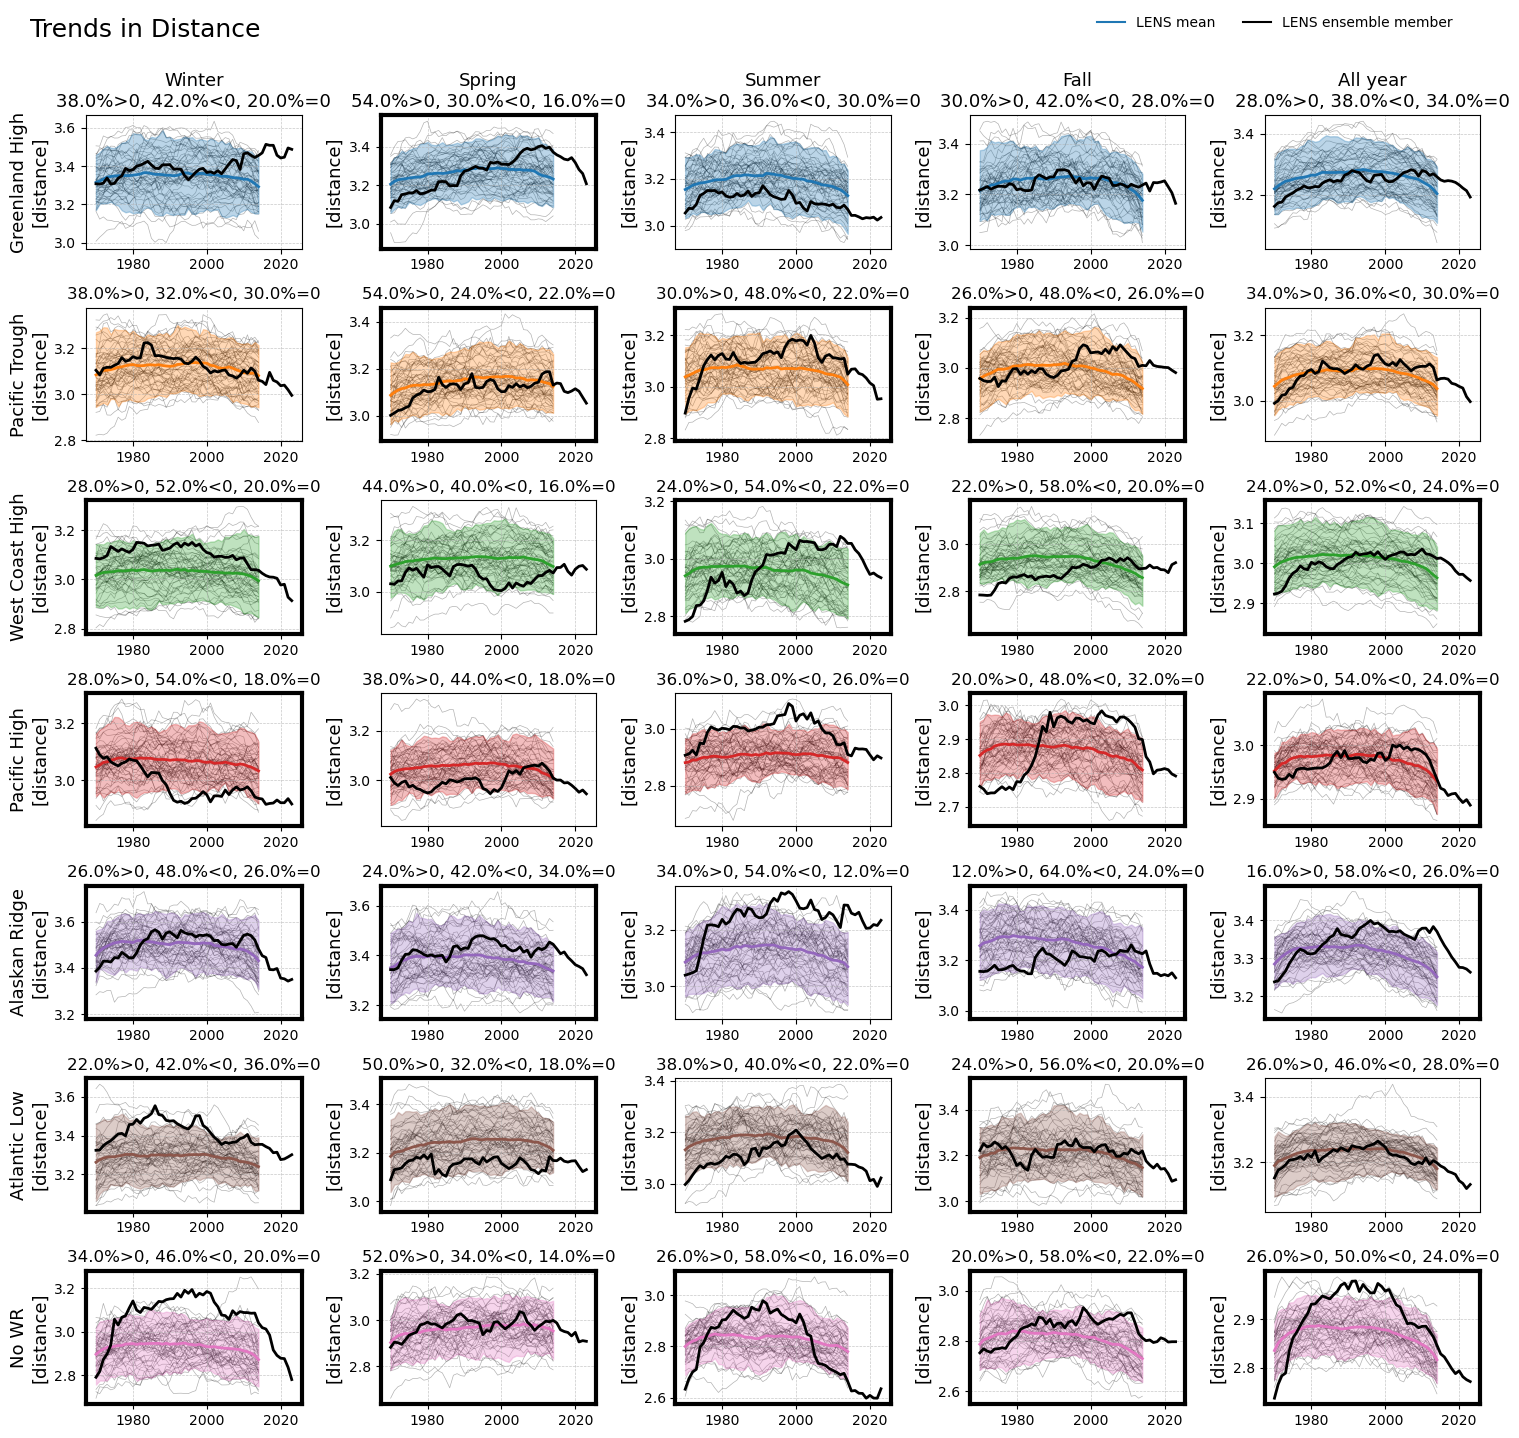

In [40]:
import matplotlib.lines as mlines

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
season_titles = ['Winter', 'Spring', 'Summer', 'Fall', 'All year']
alpha=0.05

    fig, axes = plt.subplots(nrows=len(names_wrs), ncols=5, figsize=(15, 10))  # Adjust figsize to accommodate more subplots
    axes = axes.flatten()
    
    # Iterate over each weather regime (rows)
    for wr in range(len(names_wrs)):
    # Iterate over each season (columns)
    for iseason, season in enumerate(['Winter', 'Spring', 'Summer', 'Fall', 'all']):
        ax = axes[wr * 5 + iseason]
        
        df_temp_30 = dic_dist_ts[season][wr].mean(axis=1)
        ax.plot(df_temp_30, color=colors[wr], ls='solid', zorder=10, lw=2)
        p5=dic_dist_ts[season][wr].quantile(0.05,axis=1)
        p95=dic_dist_ts[season][wr].quantile(0.95,axis=1)
        ax.fill_between(df_temp_30.index, p5, p95, color=colors[wr], alpha=0.3)
        # Plot other reanalyses with dashed lines if significance is approved
        approval30 = compute_significance_approval_30(df_temp_30, 30)
        ax.plot(dics_distances_30['ERA5'][season][wr], color='k', ls='solid', zorder=10, lw=2)
        if approval30:
            for spine in ax.spines.values():
                spine.set_linewidth(3)  # Set the thickness of the border (default is 1)
        
        pvals = []
        trends = []
        
        for name_exp in dic_dist_ts[season][wr].keys():
            df_temp_30 = dic_dist_ts[season][wr][name_exp]
            trend, pval = compute_trend_significance(df_temp_30)
            pvals.append(pval)
            trends.append(trend)
            ax.plot(df_temp_30, color='k', ls='solid', zorder=0, lw=0.5,alpha=0.3)
        
        pvals = np.array(pvals)
        trends = np.array(trends)
        
        conf_pos = 100 * len(np.where((trends>0)&(pvals<=alpha))[0])/len(trends)
        conf_neg = 100 * len(np.where((trends<0)&(pvals<=alpha))[0])/len(trends)
        conf_neu = 100 * len(np.where((pvals>=alpha))[0])/len(trends)
        text_trend = f"{np.round(conf_pos,0)}%>0, {np.round(conf_neg,0)}%<0, {np.round(conf_neu,0)}%=0"
        ax.set_title(text_trend)
        # Set the title for each season column (first row only)
        if wr == 0:
            ax.set_title(season_titles[iseason]+"\n"+text_trend, fontsize=13)
        # ax.set_ylim(p5.min()*0.98,p95.max()*1.02)
        # Set y-axis label for the first column in each row
        if iseason == 0:
            ax.set_ylabel(f'{names_wrs[wr]}\n[distance]', fontsize=13)
        else:
            ax.set_ylabel(f'[distance]', fontsize=13)
        
        # Add transparent gridlines
        ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

        # Set font sizes for axes labels
        ax.tick_params(axis='both', which='major', labelsize=10)

# Add a main title to the entire plot
fig.suptitle("Trends in Distance", fontsize=18, y=0.95, x=0.1)

# Adjust layout to prevent overlapping
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Create custom legend handles for the top-right corner
legend_lines = [
    mlines.Line2D([], [], color=colors[0], linestyle='solid', label='LENS mean'),
    # mlines.Line2D([], [], color=colors[0], linestyle='dashed', label='ERA5 5-yr window'),
    mlines.Line2D([], [], color='k', linestyle='solid', label='LENS ensemble member'),
    # mlines.Line2D([], [], color='k', linestyle='dotted', label='Other reanalyses 5-yr window')
]

# Add the legend to the top right of the figure
fig.legend(handles=legend_lines,ncol=2, loc='upper right', bbox_to_anchor=(0.98, 0.96), fontsize=10, frameon=False)

plt.savefig('../Figures/LENS_DistanceTrends_7x5_v3.png')

In [ ]:
def process_latitude(i, dataset_era5, pressure):
    start_time = time.time()
    print(f"Procesando latitud {i+1}/{len(dataset_era5['latitude'])}")
    
    results_lat = np.empty((len(dataset_era5['time']), len(dataset_era5['longitude'])))
    for j in range(len(dataset_era5['longitude'])):
        time_serie = dataset_era5[:,pressure, i, j].values  # Extraer la serie temporal en cada punto y nivel de presión
        coeffs, freqs = apply_wavelet_transform(time_serie)
        filtered_signal = remove_diurnal_cycle(coeffs, freqs, time_serie)  # Filtro el ciclo diurno
        results_lat[:, j] = filtered_signal
    
    end_time = time.time()
    print(f"Latitud {i+1}/{len(dataset_era5['latitude'])} completada en {end_time - start_time:.2f} segundos")
    
    return i, results_lat

def parallel_wavelet_processing(dataset_era5, pressure):
    # Crear el array vacío para guardar resultados
    results = xr.DataArray(np.empty((len(dataset_era5['time']), 1, len(dataset_era5['latitude']), len(dataset_era5['longitude']))),
                           dims=['time', 'level', 'latitude', 'longitude'],
                           coords={'time': dataset_era5['time'], 
                                   'level': np.array([pressure]), 
                                   'latitude': dataset_era5['latitude'], 
                                   'longitude': dataset_era5['longitude']})

    # Preparar el pool de multiprocessing
    print("Iniciando procesamiento paralelo...")
    with mp.Pool(processes=mp.cpu_count()) as pool:
        # Aplicar la función process_latitude en paralelo para cada latitud
        results_async = [pool.apply_async(process_latitude, args=(i, dataset_era5, pressure)) for i in range(len(dataset_era5['latitude']))]
        
        # Obtener y guardar los resultados a medida que se completan
        for result in results_async:
            i, results_lat = result.get()  # Recibo el índice de latitud y los resultados
            print(f"Guardando resultados para latitud {i+1}")
            results[:, 0, i, :] = results_lat

    print("Procesamiento completado.")
    return results

# Usar la función para procesar los datos
pressure = 1
results = parallel_wavelet_processing(dataset_era5, pressure)

# Guardar los resultados a un archivo NetCDF
print("Guardando resultados en archivo NetCDF...")
results.to_netcdf(f'./posproc_era5/{variable}/wavelet_{name_var}_{pressure}.nc', engine='netcdf4')
print("Archivo NetCDF guardado exitosamente.")